# GSRAP DEMO
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opensrcai/GSRAP/blob/main/example_py/notebooks/PnpRelocalize.ipynb)

# Setup packages

In [1]:
! pip install matplotlib numpy opencv-python scipy nanobind

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 3.3 MB/s eta 0:00:00


In [2]:
!rm -rf GSRAP && git clone --recursive https://github.com/opensrcai/GSRAP && \
 cd GSRAP && pip install .

Cloning into 'GSRAP'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 232 (delta 52), reused 232 (delta 52), pack-reused 0 (from 0)
Receiving objects: 100% (232/232), 422.93 KiB | 2.98 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Submodule 'third_party/eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'third_party/eigen'
Submodule 'third_party/spdlog' (https://github.com/gabime/spdlog.git) registered for path 'third_party/spdlog'
Cloning into '/content/GSRAP/third_party/eigen'...
remote: Enumerating objects: 126227, done.        
remote: Counting objects: 100% (931/931), done.        
remote: Compressing objects: 100% (280/280), done.        
remote: Total 126227 (delta 650), reused 924 (delta 649), pack-reused 125296 (from 1)        
Receiving objects: 100% (126227/126227), 105.77 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (104526/104526), done.
Cloning

# Import modules and define visualization functions

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from scipy.spatial.transform import Rotation
import gsrap
import multiprocessing
from typing import cast

from matplotlib import animation, rc
from matplotlib.animation import ArtistAnimation

In [4]:
"""

By downloading, copying, installing or using the software you agree to this license.
If you do not agree to this license, do not download, install,
copy or use the software.


                          License Agreement
               For Open Source Computer Vision Library
                       (3-clause BSD License)

Copyright (C) 2000-2018, Intel Corporation, all rights reserved.
Copyright (C) 2009-2011, Willow Garage Inc., all rights reserved.
Copyright (C) 2009-2016, NVIDIA Corporation, all rights reserved.
Copyright (C) 2010-2013, Advanced Micro Devices, Inc., all rights reserved.
Copyright (C) 2015-2016, OpenCV Foundation, all rights reserved.
Copyright (C) 2015-2016, Itseez Inc., all rights reserved.
Third party copyrights are property of their respective owners.

Redistribution and use in source and binary forms, with or without modification,
are permitted provided that the following conditions are met:

  * Redistributions of source code must retain the above copyright notice,
    this list of conditions and the following disclaimer.

  * Redistributions in binary form must reproduce the above copyright notice,
    this list of conditions and the following disclaimer in the documentation
    and/or other materials provided with the distribution.

  * Neither the names of the copyright holders nor the names of the contributors
    may be used to endorse or promote products derived from this software
    without specific prior written permission.

This software is provided by the copyright holders and contributors "as is" and
any express or implied warranties, including, but not limited to, the implied
warranties of merchantability and fitness for a particular purpose are disclaimed.
In no event shall copyright holders or contributors be liable for any direct,
indirect, incidental, special, exemplary, or consequential damages
(including, but not limited to, procurement of substitute goods or services;
loss of use, data, or profits; or business interruption) however caused
and on any theory of liability, whether in contract, strict liability,
or tort (including negligence or otherwise) arising in any way out of
the use of this software, even if advised of the possibility of such damage.

"""

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from numpy import linspace


def inverse_homogeneoux_matrix(M):
    R = M[0:3, 0:3]
    T = M[0:3, 3]
    M_inv = np.identity(4)
    M_inv[0:3, 0:3] = R.T
    M_inv[0:3, 3] = -(R.T).dot(T)

    return M_inv


def transform_to_matplotlib_frame(cMo, X, inverse=False):
    M = np.identity(4)
    # y軸とz軸を入れ替え(y軸が上下方向)
    M[1, 1] = 0
    M[1, 2] = 1
    M[2, 1] = 1
    M[2, 2] = 0

    if inverse:
        return M.dot(inverse_homogeneoux_matrix(cMo).dot(X))
    else:
        return M.dot(cMo.dot(X))


def create_camera_model(
    camera_matrix, width, height, scale_focal, draw_frame_axis=False
):
    fx = camera_matrix[0, 0]
    fy = camera_matrix[1, 1]
    focal = 2 / (fx + fy)
    f_scale = scale_focal * focal

    # draw image plane
    X_img_plane = np.ones((4, 5))
    X_img_plane[0:3, 0] = [-width, height, f_scale]
    X_img_plane[0:3, 1] = [width, height, f_scale]
    X_img_plane[0:3, 2] = [width, -height, f_scale]
    X_img_plane[0:3, 3] = [-width, -height, f_scale]
    X_img_plane[0:3, 4] = [-width, height, f_scale]

    # draw triangle above the image plane
    X_triangle = np.ones((4, 3))
    X_triangle[0:3, 0] = [-width, -height, f_scale]
    X_triangle[0:3, 1] = [0, -2 * height, f_scale]
    X_triangle[0:3, 2] = [width, -height, f_scale]

    # draw camera
    X_center1 = np.ones((4, 2))
    X_center1[0:3, 0] = [0, 0, 0]
    X_center1[0:3, 1] = [-width, height, f_scale]

    X_center2 = np.ones((4, 2))
    X_center2[0:3, 0] = [0, 0, 0]
    X_center2[0:3, 1] = [width, height, f_scale]

    X_center3 = np.ones((4, 2))
    X_center3[0:3, 0] = [0, 0, 0]
    X_center3[0:3, 1] = [width, -height, f_scale]

    X_center4 = np.ones((4, 2))
    X_center4[0:3, 0] = [0, 0, 0]
    X_center4[0:3, 1] = [-width, -height, f_scale]

    # draw camera frame axis
    X_frame1 = np.ones((4, 2))
    X_frame1[0:3, 0] = [0, 0, 0]
    X_frame1[0:3, 1] = [f_scale / 2, 0, 0]

    X_frame2 = np.ones((4, 2))
    X_frame2[0:3, 0] = [0, 0, 0]
    X_frame2[0:3, 1] = [0, f_scale / 2, 0]

    X_frame3 = np.ones((4, 2))
    X_frame3[0:3, 0] = [0, 0, 0]
    X_frame3[0:3, 1] = [0, 0, f_scale / 2]

    if draw_frame_axis:
        return [
            X_img_plane,
            X_triangle,
            X_center1,
            X_center2,
            X_center3,
            X_center4,
            X_frame1,
            X_frame2,
            X_frame3,
        ]
    else:
        return [X_img_plane, X_triangle, X_center1, X_center2, X_center3, X_center4]


def create_board_model(
    extrinsics, board_width, board_height, square_size, draw_frame_axis=False
):
    width = board_width * square_size
    height = board_height * square_size

    # draw calibration board
    X_board = np.ones((4, 5))
    # X_board_cam = np.ones((extrinsics.shape[0],4,5))
    X_board[0:3, 0] = [0, 0, 0]
    X_board[0:3, 1] = [width, 0, 0]
    X_board[0:3, 2] = [width, height, 0]
    X_board[0:3, 3] = [0, height, 0]
    X_board[0:3, 4] = [0, 0, 0]

    # draw board frame axis
    X_frame1 = np.ones((4, 2))
    X_frame1[0:3, 0] = [0, 0, 0]
    X_frame1[0:3, 1] = [height / 2, 0, 0]

    X_frame2 = np.ones((4, 2))
    X_frame2[0:3, 0] = [0, 0, 0]
    X_frame2[0:3, 1] = [0, height / 2, 0]

    X_frame3 = np.ones((4, 2))
    X_frame3[0:3, 0] = [0, 0, 0]
    X_frame3[0:3, 1] = [0, 0, height / 2]

    if draw_frame_axis:
        return [X_board, X_frame1, X_frame2, X_frame3]
    else:
        return [X_board]


def draw_camera_boards(
    ax,
    camera_matrix,
    cam_width,
    cam_height,
    scale_focal,
    extrinsics,
    board_width,
    board_height,
    square_size,
    patternCentric,
):
    min_values = np.zeros((3, 1))
    min_values = np.inf
    max_values = np.zeros((3, 1))
    max_values = -np.inf

    if patternCentric:
        X_moving = create_camera_model(
            camera_matrix, cam_width, cam_height, scale_focal
        )
        X_static = create_board_model(
            extrinsics, board_width, board_height, square_size
        )
    else:
        X_static = create_camera_model(
            camera_matrix, cam_width, cam_height, scale_focal, True
        )
        X_moving = create_board_model(
            extrinsics, board_width, board_height, square_size
        )

    cm_subsection = linspace(0.0, 1.0, extrinsics.shape[0])
    colors = [cm.jet(x) for x in cm_subsection]

    for i in range(len(X_static)):
        X = np.zeros(X_static[i].shape)
        for j in range(X_static[i].shape[1]):
            X[:, j] = transform_to_matplotlib_frame(np.eye(4), X_static[i][:, j])
        ax.plot3D(X[0, :], X[1, :], X[2, :], color="r")
        min_values = np.minimum(min_values, X[0:3, :].min(1))
        max_values = np.maximum(max_values, X[0:3, :].max(1))

    for idx in range(extrinsics.shape[0]):
        R, _ = cv.Rodrigues(extrinsics[idx, 0:3])
        cMo = np.eye(4, 4)
        cMo[0:3, 0:3] = R
        cMo[0:3, 3] = extrinsics[idx, 3:6]
        for i in range(len(X_moving)):
            X = np.zeros(X_moving[i].shape)
            for j in range(X_moving[i].shape[1]):
                X[0:4, j] = transform_to_matplotlib_frame(
                    cMo, X_moving[i][0:4, j], patternCentric
                )
            ax.plot3D(X[0, :], X[1, :], X[2, :], color=colors[idx])
            min_values = np.minimum(min_values, X[0:3, :].min(1))
            max_values = np.maximum(max_values, X[0:3, :].max(1))

    return min_values, max_values


camera_matrix = np.array(
    [[535.91573396, 0.0, 342.28315473], [0.0, 535.91573396, 235.5708291], [0, 0, 1]]
)

cam_width = 0.032
cam_height = 0.024
scale_focal = 40


def draw_cameras(
    ax: Axes3D,
    rotations: np.ndarray,
    translations: np.ndarray,
    colors: np.ndarray,
    scale: float = 1.0,
):
    # NOTE: rotations and translations are "world to local" transformation.
    assert rotations.ndim == 3
    assert translations.ndim == 2
    assert colors.ndim == 2
    assert rotations.shape[0] == translations.shape[0]
    assert translations.shape[0] == colors.shape[0]
    assert rotations.shape[1] == 3
    assert rotations.shape[2] == 3
    assert translations.shape[1] == 3
    assert colors.shape[1] == 3

    camera_model = create_camera_model(
        camera_matrix, cam_width * scale, cam_height * scale, scale_focal * scale
    )

    n = rotations.shape[0]

    min_values: float = float("inf")
    max_values: float = -float("inf")

    plot3D_list = []
    for idx in range(n):
        R = rotations[idx]
        t = translations[idx]

        cMo = np.eye(4, 4)
        cMo[0:3, 0:3] = R
        cMo[0:3, 3] = t

        for i in range(len(camera_model)):
            X = np.zeros(camera_model[i].shape)
            for j in range(camera_model[i].shape[1]):
                X[0:4, j] = transform_to_matplotlib_frame(
                    cMo, camera_model[i][0:4, j], True
                )
            plot3D_list = plot3D_list + ax.plot3D(X[0, :], X[1, :], X[2, :], color=colors[idx])
            min_values = np.minimum(min_values, X[0:3, :].min(1))
            max_values = np.maximum(max_values, X[0:3, :].max(1))
    return min_values, max_values, plot3D_list


In [5]:
from mpl_toolkits.mplot3d import Axes3D


def draw_point_cloud(ax: Axes3D, pts: np.ndarray, clr: np.ndarray=np.array([1,0,0])):
    min_values = np.full((3), np.inf)
    max_values = np.full((3), -np.inf)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], color=clr)
    min_values = np.minimum(min_values, pts[:, 0:3].min(0, keepdims=False))
    max_values = np.maximum(max_values, pts[:, 0:3].max(0, keepdims=False))

    return min_values, max_values

# Demo of PnP Relocalization

## Define sample function

In [6]:
def sample_in_unit_sphere(u: np.ndarray, v: np.ndarray, w: np.ndarray):
    cos_theta = -2 * u + 1
    sin_theta = np.sqrt(1 - cos_theta * cos_theta)
    phi = 2 * np.pi * v
    r = np.power(w, 1.0 / 3.0)

    x = r * sin_theta * np.cos(phi)
    y = r * sin_theta * np.sin(phi)
    z = r * cos_theta

    return np.stack([x, y, z], axis=-1)

In [7]:

def sample_in_unit_sphere_surface(u: np.ndarray, v: np.ndarray):
    cos_theta = -2 * u + 1
    sin_theta = np.sqrt(1 - cos_theta * cos_theta)
    phi = 2 * np.pi * v

    x = sin_theta * np.cos(phi)
    y = sin_theta * np.sin(phi)
    z = cos_theta

    return np.stack([x, y, z], axis=-1)



## Creates Cameras

In [8]:
num_camera = 8
target_center = np.array([0, 0, 0])
target_radius = 0.25

In [9]:
target = sample_in_unit_sphere(np.random.rand(num_camera), np.random.rand(num_camera), np.random.rand(num_camera))
target = target * target_radius + target_center
target

array([[ 0.22949454, -0.00795532, -0.0115163 ],
       [ 0.02617706, -0.17018611,  0.04309665],
       [ 0.1670558 , -0.12046129, -0.08371826],
       [-0.04211435, -0.10278785, -0.15885388],
       [-0.07512426, -0.06120081,  0.09246992],
       [-0.06064358, -0.10134784, -0.17879734],
       [ 0.01253335, -0.18012509,  0.08206287],
       [-0.12528503, -0.18269724,  0.05820355]])

In [10]:
ups = np.array([[0, -1, 0] for _ in range(num_camera)])
ups

array([[ 0, -1,  0],
       [ 0, -1,  0],
       [ 0, -1,  0],
       [ 0, -1,  0],
       [ 0, -1,  0],
       [ 0, -1,  0],
       [ 0, -1,  0],
       [ 0, -1,  0]])

In [11]:
circle_y_coord = 0.5
circle_center_x = 0
circle_center_z = 0
circle_radius = 2

eyes = np.array([[np.cos(2 * np.pi * (i / num_camera)), circle_y_coord, np.sin(2 * np.pi * (i / num_camera))] for i in range(num_camera)])
eyes[:, 0] = eyes[:, 0] * circle_radius + circle_center_x
eyes[:, 2] = eyes[:, 2] * circle_radius + circle_center_z
eyes

array([[ 2.00000000e+00,  5.00000000e-01,  0.00000000e+00],
       [ 1.41421356e+00,  5.00000000e-01,  1.41421356e+00],
       [ 1.22464680e-16,  5.00000000e-01,  2.00000000e+00],
       [-1.41421356e+00,  5.00000000e-01,  1.41421356e+00],
       [-2.00000000e+00,  5.00000000e-01,  2.44929360e-16],
       [-1.41421356e+00,  5.00000000e-01, -1.41421356e+00],
       [-3.67394040e-16,  5.00000000e-01, -2.00000000e+00],
       [ 1.41421356e+00,  5.00000000e-01, -1.41421356e+00]])

In [12]:
def normalize(v: np.ndarray):
  norm = np.linalg.norm(v, axis=-1)

  return v / np.expand_dims(norm, axis=-1)

def look_at(eyes:np.ndarray, targets: np.ndarray, ups: np.ndarray):
  assert eyes.shape[0] == targets.shape[0]
  assert targets.shape[0] == ups.shape[0]
  num_camera = eyes.shape[0]

  T = np.array([np.eye(4) for _ in range(num_camera)])
  T[:, 0:3, 3] =  -eyes

  R = np.array([np.eye(4) for _ in range(num_camera)])
  zs = normalize(targets - eyes)
  xs = normalize(np.cross(ups, zs, axis=-1))
  ys = normalize(np.cross(zs, xs, axis=-1))

  R[:, 0, 0:3] = xs
  R[:, 1, 0:3] = ys
  R[:, 2, 0:3] = zs

  return R @ T

transforms = look_at(eyes, target, ups)
transforms


array([[[ 6.50438818e-03,  0.00000000e+00, -9.99978846e-01,
         -1.30087764e-02],
        [ 2.75762105e-01, -9.61224242e-01,  1.79370172e-03,
         -7.09120893e-02],
        [-9.61203909e-01, -2.75767939e-01, -6.25217560e-03,
          2.06029179e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]],

       [[ 7.02757471e-01,  0.00000000e+00, -7.11429503e-01,
          1.22641049e-02],
        [ 2.31120739e-01, -9.45759340e-01,  2.28303472e-01,
         -1.76844280e-01],
        [-6.72841097e-01, -3.24868083e-01, -6.64639442e-01,
          2.05391716e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]],

       [[ 9.96801638e-01,  0.00000000e+00,  7.99155506e-02,
         -1.59831101e-01],
        [-2.27395368e-02, -9.58662809e-01,  2.83634503e-01,
         -8.79376013e-02],
        [ 7.66120663e-02, -2.84544580e-01, -9.55596658e-01,
          2.05346561e+00],
        [ 0.00000000e+00,  0.00000000e+

In [13]:
rotations = transforms[:, 0:3, 0:3]
translations = transforms[:, 0:3, 3]

rotations, translations

(array([[[ 0.00650439,  0.        , -0.99997885],
         [ 0.27576211, -0.96122424,  0.0017937 ],
         [-0.96120391, -0.27576794, -0.00625218]],
 
        [[ 0.70275747,  0.        , -0.7114295 ],
         [ 0.23112074, -0.94575934,  0.22830347],
         [-0.6728411 , -0.32486808, -0.66463944]],
 
        [[ 0.99680164,  0.        ,  0.07991555],
         [-0.02273954, -0.95866281,  0.2836345 ],
         [ 0.07661207, -0.28454458, -0.95559666]],
 
        [[ 0.75360492,  0.        ,  0.65732764],
         [-0.1823686 , -0.96074313,  0.20907971],
         [ 0.63152302, -0.27743942, -0.72402075]],
 
        [[-0.04798409,  0.        ,  0.9988481 ],
         [-0.27927902, -0.96011626, -0.0134164 ],
         [ 0.9590103 , -0.27960109,  0.0460703 ]],
 
        [[-0.67413484,  0.        ,  0.7386083 ],
         [-0.23028575, -0.95015323, -0.210184  ],
         [ 0.70179106, -0.31178332,  0.64053139]],
 
        [[-0.99998188,  0.        ,  0.00601957],
         [-0.00186912, -0.950571

## Create point cloud

In [14]:
num_points = 512 * 8

point_cloud_center = np.array([0, 0, 0])
point_cloud_radius = np.array([0.5, 0.5, 0.5])

In [15]:
point_cloud = sample_in_unit_sphere(np.random.rand(num_points), np.random.rand(num_points), np.random.rand(num_points))
point_cloud = point_cloud * point_cloud_radius + point_cloud_center

point_cloud.shape


(4096, 3)

## Creates GT correspondeces

In [16]:
num_correspondences_each_camera = int(num_points * 0.75)
num_correspondences_each_camera

3072

In [17]:
# correspondences = np.repeatk(np.arange(num_points)[None, :], num_camera, axis=0)
gt_correspondences = np.zeros((num_camera, num_correspondences_each_camera), dtype=np.int64)
rng = np.random.default_rng(12345)
for i in range(num_camera):
    gt_correspondence = np.arange(num_points, dtype=np.int64)
    rng.shuffle(gt_correspondence)
    gt_correspondences[i, :] = gt_correspondence[:num_correspondences_each_camera]


# gt_correspondences = np.stack([gt_correspondences, gt_correspondences], axis=-1)
gt_correspondences.shape, gt_correspondences.dtype

((8, 3072), dtype('int64'))

## Creates GT bearing vectors

In [18]:
def to_bearing_vectors(points: np.ndarray, rotations: np.ndarray, translations: np.ndarray):
    "`rotations` and `translations` are world to local transfomation."
    assert points.ndim == 3
    assert points.shape[2] == 3

    points_c = (rotations[:, None, :, :] @ points[:, :, :, None]).squeeze(
        -1
    ) + translations[:, None, :]

    return normalize(points_c)

In [19]:
gt_bearings = to_bearing_vectors(point_cloud[gt_correspondences], rotations, translations)

gt_bearings.shape, np.linalg.norm(gt_bearings, axis=2)

((8, 3072, 3),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

## Add Noise to bearing vectors

In [20]:
def create_onb(ns: np.ndarray):
    num = ns.size // 3

    nsx = ns.reshape(-1, 3)[:, 0]
    nsy = ns.reshape(-1, 3)[:, 1]
    nsz = ns.reshape(-1, 3)[:, 2]

    sign = np.ones(num)
    sign[nsz <= 0] = -1

    a = -1 / (sign + nsz)
    b = nsx * nsy * a

    x = np.stack(
        [1.0 + sign * nsx * nsx * a, sign * b, -sign * nsx], axis=1
    )
    y = np.stack(
        [b, sign + nsy * nsy * a, -nsy], axis=1
    )

    return x.reshape(ns.shape), y.reshape(ns.shape)

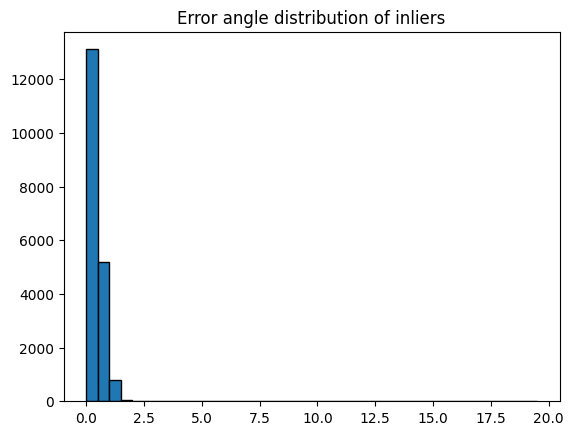

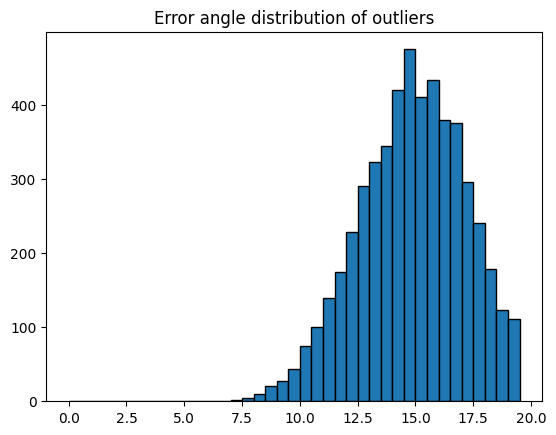

In [21]:
def rotate_bearing_vectors_axis_angle(bearings: np.ndarray, axis: np.ndarray, theta: np.ndarray):
    dots = axis[:,None,:] @ axis[:,None,:].transpose(0, 2, 1)

    rotation_vectors = theta[..., None] * axis
    rotations = Rotation.from_rotvec(rotation_vectors)
    rotated = rotations.apply(bearings.reshape(-1, 3))
    return rotated.reshape(bearings.shape)


def add_noise_to_bearing_vectors(bearings: np.ndarray,
                                 inlier_angle_mean: float,
                                 inlier_angle_std: float,
                                 outlier_angle_mean: float,
                                 outlier_angle_std: float,
                                 outlier_ratio: float):

    num_points = bearings.size // 3
    original_shape = bearings.shape
    bearings = bearings.reshape(-1, 3)

    xs, ys = create_onb(bearings.reshape(num_points, 3))

    phi = 2.0 * np.pi * np.random.rand(num_points)
    axis = np.cos(phi)[..., None] * xs + np.sin(phi)[..., None] * ys

    num_outlier = int(outlier_ratio * num_points)

    is_outlier_bearings = np.full(num_points, fill_value=False)
    is_outlier_bearings[np.random.choice(num_points, size=num_outlier)] = True
    is_outlier_bearings = is_outlier_bearings.reshape(bearings.shape[:-1])

    inlier_bearings = bearings[np.logical_not(is_outlier_bearings), :]
    inlier_axis = axis[np.logical_not(is_outlier_bearings), :]
    inlier_theta = np.random.normal(loc=inlier_angle_mean, scale=inlier_angle_std, size=inlier_bearings.shape[:-1])

    tmp = inlier_bearings.copy()
    inlier_bearings = rotate_bearing_vectors_axis_angle(inlier_bearings, inlier_axis, inlier_theta)

    dots = inlier_bearings.reshape(-1, 1, 3) @ tmp.reshape(-1, 1, 3).transpose(0, 2, 1)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    num_bin = 40
    ax.set_title('Error angle distribution of inliers', loc='center')
    # ax.hist(inlier_theta * 180 / np.pi, bins=[20 * (i / num_bin) for i in range(num_bin)], histtype='barstacked', ec='black')
    ax.hist(np.arccos(dots.flatten()) * 180 / np.pi, bins=[20 * (i / num_bin) for i in range(num_bin)], histtype='barstacked', ec='black')

    outlier_bearings = bearings[is_outlier_bearings, :]
    outlier_axis = axis[is_outlier_bearings, :]
    outlier_theta = np.random.normal(loc=outlier_angle_mean, scale=outlier_angle_std, size=outlier_bearings.shape[:-1])

    tmp = outlier_bearings.copy()
    outlier_bearings = rotate_bearing_vectors_axis_angle(outlier_bearings, outlier_axis, outlier_theta)

    dots = outlier_bearings.reshape(-1, 1, 3) @ tmp.reshape(-1, 1, 3).transpose(0, 2, 1)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    num_bin = 40
    ax.set_title('Error angle distribution of outliers', loc='center')
    # ax.hist(inlier_theta * 180 / np.pi, bins=[20 * (i / num_bin) for i in range(num_bin)], histtype='barstacked', ec='black')
    ax.hist(np.arccos(dots.flatten()) * 180 / np.pi, bins=[20 * (i / num_bin) for i in range(num_bin)], histtype='barstacked', ec='black')

    out = bearings.copy()
    out[np.logical_not(is_outlier_bearings), :] = inlier_bearings
    bearings[is_outlier_bearings, :] = outlier_bearings

    return out.reshape(original_shape), is_outlier_bearings.reshape(original_shape[:-1])

bearings, is_outlier_bearings = add_noise_to_bearing_vectors(gt_bearings, 0, 0.5 * np.pi / 180, 15 * np.pi / 180, 2.5 * np.pi / 180, 0.25)

array([ 0.18606282, 16.87243409,  0.75464182, ...,  0.49163636,
       16.89015602,  0.17017226])

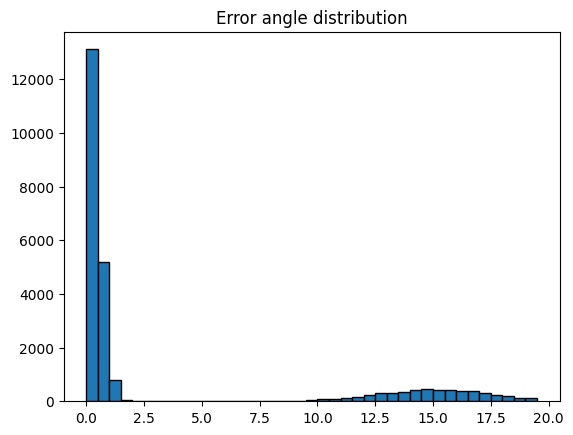

In [22]:
# Visualize the angle between bearings and gt_bearings
angles = (np.arccos(bearings.reshape(-1, 1, 3) @ gt_bearings.reshape(-1, 1, 3).transpose(0, 2, 1)) * 180 / np.pi).flatten()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
num_bin = 40
ax.set_title('Error angle distribution', loc='center')
ax.hist(angles, bins=[20 * (i / num_bin) for i in range(num_bin)], histtype='barstacked', ec='black')

angles

## Creates pairs

In [23]:
gt_pairs = np.arange(num_correspondences_each_camera)[None, :].repeat(num_camera, axis = 0)[...,None].repeat(2, axis=-1)

gt_pairs.shape

(8, 3072, 2)

## add outliers to pairs

In [24]:
shuffle = np.zeros((num_camera, num_correspondences_each_camera), dtype=np.int64)

for i in range(num_camera):
    arange = np.arange(num_correspondences_each_camera, dtype=np.int64)
    tmp = arange.copy()

    while True:
        rng.shuffle(tmp)
        neq = (tmp != arange)
        if neq.all():
            shuffle[i, :] = tmp
            break
num_outlier_correspondences_each_camera = int(num_correspondences_each_camera * 0.1)

shuffle = shuffle[:, :num_outlier_correspondences_each_camera]

arange = np.arange(num_outlier_correspondences_each_camera)[None, :].repeat(num_camera, axis=0)

pairs = gt_pairs.copy()

for i in range(num_camera):
    pairs[i, arange[i], 0] = gt_pairs[i, shuffle[i], 0]

In [25]:
is_inlier = (pairs[..., 0] == gt_pairs[..., 0])

for i in range(num_camera):
    is_inlier[i, ...] = np.logical_and(np.logical_not(is_outlier_bearings[i, pairs[i, :, 0]]), is_inlier[i, ...])

is_inlier.sum(axis=1) / num_correspondences_each_camera * 100

array([69.82421875, 70.18229167, 69.95442708, 68.78255208, 69.49869792,
       70.80078125, 70.93098958, 70.1171875 ])

## Solve PnP Problem

In [26]:
rotations_relocalized = np.zeros((num_camera, 3, 3), dtype=np.float64)
translations_relocalized = np.zeros((num_camera, 3), dtype=np.float64)
for i in range(num_camera):
    points = point_cloud[gt_correspondences[i]]

    pnp_solver_policy = gsrap.PnpSolverPolicy()

    pnp_solver_policy.flags = (
        gsrap.PnpSolverPolicyFlags.PNP_SOLVER_POLICY_FLAGS_NONE
        | gsrap.PnpSolverPolicyFlags.PNP_SOLVER_POLICY_FLAGS_REFINE
    )

    pnp_solver_policy.ransac_policy.flags = (
        gsrap.RansacPolicyFlags.RANSAC_POLICY_FLAGS_EARLY_STOP
        | gsrap.RansacPolicyFlags.RANSAC_POLICY_FLAGS_USE_PROBABILITY_WITHOUT_DUPLICATION_SAMPLE
    )

    pnp_solver_policy.ransac_policy.num_threads = multiprocessing.cpu_count()
    pnp_solver_policy.ransac_policy.num_ransac_itr_lower_limit = 10
    pnp_solver_policy.ransac_policy.num_ransac_itr_upper_limit = 1000

    pnp_inlier_check_params = gsrap.PnpInlierCheckParamsUsingBearingVector()
    pnp_inlier_check_params.inlier_thr = 1e-2
    pnp_solver_policy.pnp_inlier_check_params = pnp_inlier_check_params

    ret = gsrap.solve_pnp_problem(pnp_solver_policy, bearings[i], points, pairs[i])

    pnp_solver_result = ret[0]
    if pnp_solver_result is not None:
        pnp_solver_result = cast(gsrap.PnpSolverResult, pnp_solver_result)

        print("R:\n", pnp_solver_result.rotation)
        print("det R: ", np.linalg.det(pnp_solver_result.rotation))
        print("gt R:\n", rotations[i])
        print("---")
        print("t:\n", pnp_solver_result.translation)
        print("gt t:\n", translations[i])
        print("inlier_ratio: ", pnp_solver_result.inlier_ratio)
        print("inliers: ", pnp_solver_result.inliers)

        rotations_relocalized[i, :, :] = pnp_solver_result.rotation
        translations_relocalized[i, :] = pnp_solver_result.translation

R:
 [[ 0.00414926  0.00551563 -0.99997618]
 [ 0.27376726 -0.96178693 -0.00416903]
 [-0.96178702 -0.27374344 -0.0055007 ]]
det R:  1.0000000000000004
gt R:
 [[ 0.00650439  0.         -0.99997885]
 [ 0.27576211 -0.96122424  0.0017937 ]
 [-0.96120391 -0.27576794 -0.00625218]]
---
t:
 [-0.01313016 -0.069936    2.05118137]
gt t:
 [-0.01300878 -0.07091209  2.06029179]
inlier_ratio:  0.6705729166666666
inliers:  [13, 308, 311, 312, 313, 314, 316, 317, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 332, 335, 337, 339, 343, 344, 345, 346, 347, 348, 350, 351, 353, 357, 358, 359, 360, 362, 363, 364, 365, 366, 367, 368, 370, 371, 372, 373, 374, 375, 377, 379, 381, 384, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 414, 415, 416, 417, 418, 420, 421, 422, 423, 424, 425, 427, 428, 429, 432, 434, 435, 436, 437, 439, 440, 441, 442, 443, 444, 446, 447, 448, 449, 451, 453, 454, 455, 457, 458, 459, 460, 461, 462, 4

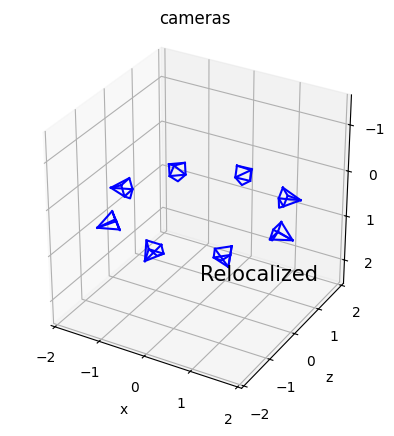

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

animation = []

color_red = np.zeros((num_camera, 3))
color_red[:, 0] = 1
color_blue = np.zeros((num_camera, 3))
color_blue[:, 2] = 1

min_values, max_values, plot_3Ds = draw_cameras(ax, rotations, translations, color_red, 5)
title = ax.text(x=0, y=0, z=2, s="GT", fontsize=15)
animation.append(plot_3Ds + [title])
min_values, max_values, plot_3Ds = draw_cameras(ax, rotations_relocalized, translations_relocalized, color_blue, 5)
title = ax.text(x=0, y=0, z=2, s="Relocalized", fontsize=15)
animation.append(plot_3Ds + [title])

X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
ax.set_title('cameras')
ax.invert_zaxis()
ax.set_box_aspect([1, 1, 1])

# ArtistAnimationの作成
ani = ArtistAnimation(fig, animation, interval=1000, blit=True)

rc('animation', html='jshtml')

ani